# 10.6 파이토치 - Cartpole을 다루는 PG 구현
정책 경사 (Polocy Gradient) 방법은 강화학습의 방법들 중에 정책 기반 방법 중의 기본적인 한 가지이다.  

## 10.6.1 라이브러리 불러들이기
__(1) 코드에 필요한 라이브러리를 불러온다.__

라이브러리를 불러오기전에 그래픽을 주피터 노트북에서 보이기 위한 주피터 확장자를 불러온다.

In [12]:
%matplotlib inline

<br>
기본적인 라이브러리들을 불러온다.아래 중에서 itertools에 있는 count()는 불특정 횟수의 반복을 위해 사전에 정해진 한계가 없이 계속 반복하며 반복 횟수를 돌려준다. 강화학습의 공개 환경 라이브러리는 done이라는 신호를 통해 끝을 알려주기 때문에 count()로 인해 무한번 반복하게 되는 상황을 방지할 수 있다. 

In [13]:
from IPython.display import clear_output
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

<br>
강화학습 환경 관리 라이브러리를 불러들인다. 강화학습은 시행착오를 통해 인공지능이 스스로 행동에 대한 정책을 최적화하는 인공지능 기법이다. 시행착오를 수행하기 위해서는 대상이 되는 환경을 제공해야 한다. Gym은 체력을 강화하는 헬쓰장의 의미와 유사하게 인공지능의 정책 최적화를 위해 환경 제공을 일괄적으로 제공하고 관리하는 환경이다.

In [14]:
import gym

<br>
파이토치를 사용하기 위해 필요한 라이브러리들을 불러들이다. 파이토치 라이브러리의 대표 명칭은 torch이다. 

In [15]:
# Using torch
import torch as TC
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli

## 10.6.2 기반 기능 구현

__(2) 강화학습에 필요한 공통 기능 구현__

In [16]:
def list_norm_inplace(buff):
    r_mean = np.mean(buff)
    r_std = np.std(buff)
    for ii in range(len(buff)):
        buff[ii] = (buff[ii] - r_mean) / r_std

        
def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = TC.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = TC.cat((TC.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    
        
def plot_durations_ii(ii, episode_durations, ee, ee_duration=100):
    episode_durations.append(ii+1)
    if (ee + 1) % ee_duration == 0:
        clear_output()
        plot_durations(episode_durations)

__(3) 정책 경사에 필요한 기반 기능 구현__

상태 정보($s_t$)를 입력해 행동에 대한 정책을 결정하는 요소인 정책 확률을 출력하는 함수형 클래스를 구현한다. 
$$p_t (a_t=1|s_t) = f_{\mathrm{PGNET}}(s_t)$$
이 정책 확률은 Bernoulli 확률 분포함수를 나타내는 torch.distributions.Bernoulli라는 함수형 클래스에 의해 정책으로 변환된다.
$$\pi_t (a_t=1|s_t) = P_{\mathrm{Bernoulli}}(p_t (a_t=1|s_t))$$

In [17]:
class PGNET(nn.Module):
    # 순수하게 Policy gradient로 구성
    def __init__(self, num_state):
        super(PGNET, self).__init__()
    
        self.fc_in = nn.Linear(num_state, 24)
        self.fc_hidden = nn.Linear(24, 36)
        self.fc_out = nn.Linear(36, 1)
        
    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc_hidden(x))
        x = TC.sigmoid(self.fc_out(x))
        return x

## 10.6.3 메인 기능 구현

(4) 정책 경사 방법의 강화학습을 위한 수행 객체

이 코드는 파이썬의 클래스 기능을 이용해 강화학습 에이전트를 만듭니다. 에이전트는 환경과의 시행착오 과정을 통해 자신의 행동에 대한 정책을 점점 학습해 나갑니다. 그리고 여기서는 코드의 나열 순서가 아니라 코드의 동작을 이해하기 쉬운 순서대로 설명합니다. 클래스 멤버 함수가 없거나 함수 내부가 비어 있어도 실제 동작에는 필요한 코드가 있으니 코드 작성시는 전체 코드를 참조하기 바랍니다. 

<br>
에이전트 실행을 위한 멤버 함수 run()을 구현한다. run()은 외부에서 부르는 실행을 위한 멤버 함수입니다. 이 함수는 두개의 멤버 함수를 부릅니다. 

첫 번째가 한번의 에피소드를 수행하는 `self.run_episode()`입니다. 강화학습은 학습 과정에서 이 과정을 시행착오라고 합니다. 지도학습은 이미 만들어진 데이터를 통해 학습하는 경우가 일반적이기 때문에 시행착오 과정이 존재하지 않는 것이 대부분입니다. 만약 지도학습에서 데이터를 받아들이는 과정이 있다면 반드시 받아들인 각 데이터에 대해 레이블링 과정이 필요합니다. 이 레이블링은 주로 사람에 의해 이루어지기 때문에 데이터를 받아들이는 과정이 있다면 굉장히 비효율적으로 동작하게 됩니다.  

두 번째가 `self.train_episode()`가 담당하는 학습 과정입니다. 시행착오 과정에서 만들어진 경험 데이터를 통해 학습이 진행됩니다. 강화학습에서는 레이블 정보 대신에 리워드를 사용합니다. 리워드는 에피소드가 수행되는 과정에서 마지막 한번 또는 중간중간에 계속해서 구해질 수 있습니다. 한번의 에피소드안에 여러번의 반복이 시도가 됨으로 각 반복시점에 생성된 데이터는 다음 3가지로 구분할 수 있습니다. 
$$\{s_k, r_k, F^\mathrm{Done}_k |k=1..K_i\}$$
여기서 $s_k$는 $k$회에서 상태, $r_k$는 $k$회에서 리워드, 그리고 $F^\mathrm{Done}_k$는 $k$회에서 완료 여부를 나타내는 플래그이다.

In [21]:
class PGNET_AGENT(PGNET): 
    def run(self, env):
        for ee in range(self.num_episode):
            self.run_episode(env, ee)
            self.train_episode(ee)

<br>그럼 `run_eisode()`를 만듭니다. env.reset()을 이용해 앞서 만든 환경을 초기화 합니다. 그 다음은 에피소드안에서 반복의 종료를 나타내는 `done_flag` 즉 $F^\mathrm{Done}_k$가 True가 될 때까지 반복 시행한다. 에이전트가 현재 가지고 있는 정책에 기반해 각 상태인 `state` 즉, $s_k$에 따른 동작인 $a_k$를 수행하고 그 결과 변화된 상태와 완료 여부 플래그 값을 가져온다. 정책은 뉴럴넷으로 구현된 정책 근사 함수를 사용하여 다음과 같은 관계를 통해 가져오게 된다.  
$$\pi(a|s_k) = f_{\theta}(s_k)$$ 
여기서 $\sum_{a \in A}  \pi(a|s_k) = 1$을 만족하는 확률 함수이다. 따라서 수행할 행동은 이 확률 조건하에서 $a_k \sim \pi(a|s_k)$와 같이 샘플링을 통해 선택된다. 
그리고 만약 완료가 되었다면 `ee_duratoin`마다 한번씩 결과를 그래프로 표시할 수 있도록 `plot_duration_ii()` 함수를 수행한다. 

In [20]:
class PGNET_AGENT(PGNET):
    def run_episode(self, env, ee):
        state = env.reset()        
        for ii in count():            
            state, done_flag = self.step(env, state, ee, ii, ee_duration=100)
            if done_flag:
                plot_durations_ii(ii, self.episode_durations, ee, ee_duration=100)
                break
                
    def run(self, env):
        pass # 내용 생략

In [10]:
class PGNET_AGENT(PGNET):
    # Policy gradient를 실제 사용하기 위해 필요한 변환을 고려함
    def __init__(self, num_state, render_flag=False):
        self.forget_factor = 0.99
        self.learning_rate = 0.01
        self.num_episode = 5000            
        self.num_batch = 5
        self.render_flag = render_flag
        self.steps_in_batch = 0
        self.episode_durations = []
        
        super().__init__(num_state)                
        self.optimizer = TC.optim.RMSprop(self.parameters(), lr=self.learning_rate)        
        self.init_buff()        
        
    def forward(self, state):
        state_var = Variable(TC.from_numpy(state).float())
        prob = super().forward(state_var)
        # check this function to know what the meaing of log_prob. Is it log(prob)?
        return Bernoulli(prob)
    
    def push_buff_done(self, reward, state, action, done_flag=False):
        if done_flag: # devide between episodes
            self.reward_buff.append(0)
        else:
            self.reward_buff.append(reward)
        self.state_buff.append(state)
        self.action_buff.append(action)
        
    def pull_buff(self, ii):
        return self.reward_buff[ii], self.state_buff[ii], self.action_buff[ii]
    
    def init_buff(self):
        self.reward_buff = []
        self.state_buff = []
        self.action_buff = []
        
    def transform_discount_reward(self, steps):
        future_reward = 0
        for ii in reversed(range(steps)):
            if self.reward_buff[ii] == 0:
                future_reward = 0
            else:
                future_reward = future_reward * self.forget_factor + self.reward_buff[ii]
                self.reward_buff[ii] = future_reward
        list_norm_inplace(self.reward_buff)
    
    def train(self, steps):
        self.transform_discount_reward(steps)
        self.optimizer.zero_grad()
        for ii in range(steps):
            reward, state, action = self.pull_buff(ii)
            action_var = Variable(TC.FloatTensor([float(action)]))
            policy = self.forward(state)
            loss = -policy.log_prob(action_var) * reward            
            loss.backward()
        self.optimizer.step()        
        self.init_buff()

    def step(self, env, state, ee, ii, ee_duration=100):        
        policy = self.forward(state)
        action = policy.sample().data.numpy().astype(int)[0]

        next_state, reward, done_flag, _ = env.step(action)
        if self.render_flag: 
            env.render()        
        self.push_buff_done(reward, state, action, done_flag)

        self.steps_in_batch += 1
        state = next_state
        
        return state, done_flag
        
    def run_episode(self, env, ee):
        state = env.reset()        
        for ii in count():            
            state, done_flag = self.step(env, state, ee, ii, ee_duration=100)
            if done_flag:
                plot_durations_ii(ii, self.episode_durations, ee, ee_duration=100)
                break

    def train_episode(self, ee):
        if ee > 0 and ee % self.num_batch == 0:
            self.train(self.steps_in_batch)  
            self.steps_in_batch = 0            
    
    def run(self, env):
        for ee in range(self.num_episode):
            self.run_episode(env, ee)
            self.train_episode(ee)

__(5) 수행 객체 호출 함수 및 호출 명령 수행__

먼저 환경을 만든다. 환경은 GYM을 사용한다. GYM은 공개 소프트웨어로 강화학습을 위한 다양한 환경을 제공한다. 여기서는 CartPole이라는 환경을 사용한다. 
- GYM을 구할 수 있는 위치: https://gym.openai.com

다음은 환경을 통해 자신을 학습시키는 에이전트의 인스턴스를 학습한다. 
그리고 생성한 에이전트를 수행한다. 여기서의 수행은 인스턴스의 학습을 의미한다. 추후로는 학습을 하고 그 후에 태스트를 하는 것까지를 포함할 예정이다.

최종적으로는 만든 환경을 닫는다.

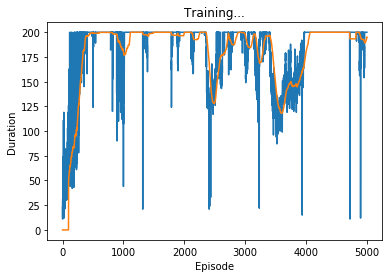

In [11]:
env = gym.make('CartPole-v0')                
a_agent = PGNET_AGENT(env.observation_space.shape[0], render_flag=False)
a_agent.run(env)        
env.close()        

---
## 전체 코드
예제 10-5 파이토치 - Cartpole을 다루는 PG 전체 코드

(1) 라이브러리 불러들이기

In [3]:
# 그래픽 처리를 위한 확장자 실행
%matplotlib inline

# 기본 라이브러리 불러들이기
from IPython.display import clear_output
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

# 강화학습 환경 관리 라이브러리 불러들이기
import gym

# 파이토치 라이브러리 불러들이기
import torch as TC
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli

(2) 강화학습에 필요한 공통 기능 구현

In [6]:
def list_norm_inplace(buff):
    r_mean = np.mean(buff)
    r_std = np.std(buff)
    for ii in range(len(buff)):
        buff[ii] = (buff[ii] - r_mean) / r_std
        
def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = TC.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = TC.cat((TC.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    
        
def plot_durations_ii(ii, episode_durations, ee, ee_duration=100):
    episode_durations.append(ii+1)
    if (ee + 1) % ee_duration == 0:
        clear_output()
        plot_durations(episode_durations)

(3) 정책경사를 위한 기반 기능 구현


In [7]:
class PGNET(nn.Module):
    # 순수하게 Policy gradient로 구성
    def __init__(self, num_state):
        super(PGNET, self).__init__()
    
        self.fc_in = nn.Linear(num_state, 24)
        self.fc_hidden = nn.Linear(24, 36)
        self.fc_out = nn.Linear(36, 1)
        
    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc_hidden(x))
        x = TC.sigmoid(self.fc_out(x))
        return x

(4) 정책 경사 방법의 강화학습을 위한 수행 객체 

In [10]:
class PGNET_AGENT(PGNET):
    # Policy gradient를 실제 사용하기 위해 필요한 변환을 고려함
    def __init__(self, num_state, render_flag=False):
        self.forget_factor = 0.99
        self.learning_rate = 0.01
        self.num_episode = 5000            
        self.num_batch = 5
        self.render_flag = render_flag
        self.steps_in_batch = 0
        self.episode_durations = []
        
        super().__init__(num_state)                
        self.optimizer = TC.optim.RMSprop(self.parameters(), lr=self.learning_rate)        
        self.init_buff()        
        
    def forward(self, state):
        state_var = Variable(TC.from_numpy(state).float())
        prob = super().forward(state_var)
        # check this function to know what the meaing of log_prob. Is it log(prob)?
        return Bernoulli(prob)
    
    def push_buff_done(self, reward, state, action, done_flag=False):
        if done_flag: # devide between episodes
            self.reward_buff.append(0)
        else:
            self.reward_buff.append(reward)
        self.state_buff.append(state)
        self.action_buff.append(action)
        
    def pull_buff(self, ii):
        return self.reward_buff[ii], self.state_buff[ii], self.action_buff[ii]
    
    def init_buff(self):
        self.reward_buff = []
        self.state_buff = []
        self.action_buff = []
        
    def transform_discount_reward(self, steps):
        future_reward = 0
        for ii in reversed(range(steps)):
            if self.reward_buff[ii] == 0:
                future_reward = 0
            else:
                future_reward = future_reward * self.forget_factor + self.reward_buff[ii]
                self.reward_buff[ii] = future_reward
        list_norm_inplace(self.reward_buff)
    
    def train(self, steps):
        self.transform_discount_reward(steps)
        self.optimizer.zero_grad()
        for ii in range(steps):
            reward, state, action = self.pull_buff(ii)
            action_var = Variable(TC.FloatTensor([float(action)]))
            policy = self.forward(state)
            loss = -policy.log_prob(action_var) * reward            
            loss.backward()
        self.optimizer.step()        
        self.init_buff()

    def step(self, env, state, ee, ii, ee_duration=100):        
        policy = self.forward(state)
        action = policy.sample().data.numpy().astype(int)[0]

        next_state, reward, done_flag, _ = env.step(action)
        if self.render_flag: 
            env.render()        
        self.push_buff_done(reward, state, action, done_flag)

        self.steps_in_batch += 1
        state = next_state
        
        return state, done_flag
        
    def run_episode(self, env, ee):
        state = env.reset()        
        for ii in count():            
            state, done_flag = self.step(env, state, ee, ii, ee_duration=100)
            if done_flag:
                plot_durations_ii(ii, self.episode_durations, ee, ee_duration=100)
                break

    def train_episode(self, ee):
        if ee > 0 and ee % self.num_batch == 0:
            self.train(self.steps_in_batch)  
            self.steps_in_batch = 0            
    
    def run(self, env):
        for ee in range(self.num_episode):
            self.run_episode(env, ee)
            self.train_episode(ee)

(5) 수행 객체 호출 함수 및 호출 명령 수행

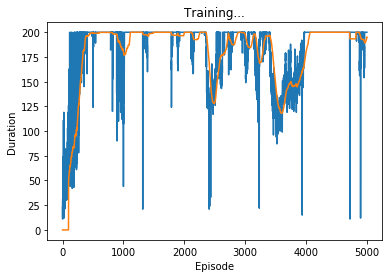

In [11]:
env = gym.make('CartPole-v0')                
a_agent = PGNET_AGENT(env.observation_space.shape[0], render_flag=False)
a_agent.run(env)        
env.close()        